# Forest cover type with multilayer perceptron

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

MAX_EPOCHS = 500

In [2]:
def get_train_test_data(add_soil_features):
    df_train = pd.read_csv("../input/train.csv").sample(frac=1)
    df_test = pd.read_csv("../input/test.csv")

    if add_soil_features:
        rubbly = ['Soil_Type' + str(num) for num in [3, 4, 5, 10, 11, 13]]
        stony  = ['Soil_Type' + str(num) for num in [6, 12]]
        very_stony = ['Soil_Type' + str(num) for num in [9, 18, 26, 2]]
        extemely_stony =['Soil_Type' + str(num) for num in [1, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36]]
        rock_land_complex = ['Soil_Type' + str(num) for num in [11, 12, 34, 40]]
        typic_cryaquolls_complex = ['Soil_Type' + str(num) for num in [20, 23]]
        rock_outcrop_complex = ['Soil_Type' + str(num) for num in [1, 3, 4, 5, 6, 10, 27, 28 , 33]]
        leighcan_family_complex = ['Soil_Type' + str(num) for num in [32, 39]]
        leighcan = ['Soil_Type' + str(num) for num in [22, 23, 24, 25, 27, 28, 31]]
        moran = ['Soil_Type' + str(num) for num in [39, 40]]

        categories = [rubbly, stony, very_stony, extemely_stony, rock_land_complex, typic_cryaquolls_complex,
                      rock_outcrop_complex, leighcan_family_complex, leighcan, moran]

        cat_num = 0
        for cat in categories:
            cat_str = 'cat' + str(cat_num)
            df_train[cat_str] = 0
            df_test[cat_str] = 0
            for soil_type in cat:
                df_train[cat_str] += df_train[soil_type]
                df_test[cat_str] += df_test[soil_type]
            cat_num += 1
            
    return df_train, df_test

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import regularizers

def create_mode__sequential(num_features, num_categories):
    model = Sequential()
    model.add(Dense(1024, activation='elu', input_dim=num_features, kernel_regularizer=regularizers.l2(0.000002)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(768, activation='elu', kernel_regularizer=regularizers.l2(0.000005)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.000007)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='elu', kernel_regularizer=regularizers.l2(0.000009)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.00001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.00007)))
    model.add(BatchNormalization())
    model.add(Dense(num_categories, activation='softmax'))
    
    return model

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import keras
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.layers.merge import concatenate

def create_model(num_features, num_categories):
    inputs = Input(shape=(num_features,))
    x = Dense(1024, activation='elu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    layer_1 = x

    x = Dense(512, activation='elu')(layer_1)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    layer_2 = x

    input_layer_3 = concatenate([layer_1, layer_2])
    x = Dense(256, activation='elu')(input_layer_3)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    layer_3 = x

    input_layer_4 = concatenate([layer_1, layer_2, layer_3])
    x = Dense(64, activation='elu')(input_layer_4)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    layer_4 = x

    input_layer_5 = concatenate([layer_2, layer_3, layer_4])
    x = Dense(32, activation='elu')(input_layer_5)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_categories, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [5]:
from sklearn import preprocessing

def prepare_data_model(df_train, df_test):
    X_train = np.array(df_train.drop(['Cover_Type', 'Id'], axis=1))
    # original y is in range 1..7 -> convert to 0..6
    y_train = np.array(df_train['Cover_Type']) - 1

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_scaled = scaler.transform(X_train)

    num_categories = len(df_train['Cover_Type'].unique())
    y_k = y_train.reshape([len(y_train), 1])
    one_hot_labels = keras.utils.to_categorical(y_k)

    model = create_model(X_train.shape[1], num_categories)

    model.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'], optimizer='adam')
    
    return model, X_scaled, one_hot_labels, scaler

In [6]:
def create_folders():
    import os
    
    os.makedirs('history', exist_ok=True)
    os.makedirs('checkpoints', exist_ok=True)
    
create_folders()

## Model without extra soil features

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

name = 'mlp_01'

df_train, df_test = get_train_test_data(add_soil_features=False)
model, X_scaled, one_hot_labels, scaler = prepare_data_model(df_train, df_test)

# log history
history_name = 'history/' + name + '.csv'
historyLogger = CSVLogger(history_name, append=False)

# safe model checkpoints
checkpoint_name = 'checkpoints/' + name + '.hdf5'
modelCheckPoint = ModelCheckpoint(checkpoint_name,
                                    monitor='val_acc', verbose=0, save_best_only=True)

# stop training when validation loss is not decreasing
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=60)

# list with callbacks for fit_generator
callbacks = [historyLogger, modelCheckPoint, earlyStopping]

model.fit(X_scaled, one_hot_labels, epochs=MAX_EPOCHS, batch_size=64, validation_split=0.2, callbacks=callbacks)

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 12096 samples, validate on 3024 samples
Epoch 1/500
12096/12096 [==============================] - 3s 243us/step - loss: 1.2339 - acc: 0.5389 - val_loss: 0.8100 - val_acc: 0.6673
Epoch 2/500
12096/12096 [==============================] - 2s 131us/step - loss: 0.9821 - acc: 0.6036 - val_loss: 0.7268 - val_acc: 0.7037
Epoch 3/500
12096/12096 [==============================] - 2s 132us/step - loss: 0.9034 - acc: 0.6279 - val_loss: 0.6874 - val_acc: 0.7186
Epoch 4/500
12096/12096 [==============================] - 2s 129us/step - loss: 0.8637 - acc: 0.6458 - val_loss: 0.6693 - val_acc: 0.7189
Epoch 5/500
12096/12096 [==============================] - 2s 129us/step - loss: 0.8226 - acc: 0.6648 - val_loss: 0.6557 - val_acc: 0.7252
Epoch 6/500
12096/12096 [==============================] - 2s 126us/step - loss: 0.8012 - acc: 0.6741 - val_lo

Epoch 55/500
12096/12096 [==============================] - 1s 120us/step - loss: 0.5572 - acc: 0.7792 - val_loss: 0.4506 - val_acc: 0.8165
Epoch 56/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.5524 - acc: 0.7808 - val_loss: 0.4461 - val_acc: 0.8274
Epoch 57/500
12096/12096 [==============================] - 1s 118us/step - loss: 0.5489 - acc: 0.7827 - val_loss: 0.4390 - val_acc: 0.8267
Epoch 58/500
12096/12096 [==============================] - 1s 117us/step - loss: 0.5456 - acc: 0.7882 - val_loss: 0.4374 - val_acc: 0.8261
Epoch 59/500
12096/12096 [==============================] - 1s 121us/step - loss: 0.5484 - acc: 0.7829 - val_loss: 0.4414 - val_acc: 0.8323
Epoch 60/500
12096/12096 [==============================] - 1s 116us/step - loss: 0.5481 - acc: 0.7865 - val_loss: 0.4394 - val_acc: 0.8304
Epoch 61/500
12096/12096 [==============================] - 1s 116us/step - loss: 0.5407 - acc: 0.7875 - val_loss: 0.4340 - val_acc: 0.8254
Epoch 62/500
12096/1

12096/12096 [==============================] - 2s 135us/step - loss: 0.4633 - acc: 0.8230 - val_loss: 0.3907 - val_acc: 0.8515
Epoch 114/500
12096/12096 [==============================] - 2s 135us/step - loss: 0.4607 - acc: 0.8242 - val_loss: 0.3858 - val_acc: 0.8604
Epoch 115/500
12096/12096 [==============================] - 2s 130us/step - loss: 0.4608 - acc: 0.8202 - val_loss: 0.3882 - val_acc: 0.8522
Epoch 116/500
12096/12096 [==============================] - 2s 125us/step - loss: 0.4563 - acc: 0.8244 - val_loss: 0.3877 - val_acc: 0.8585
Epoch 117/500
12096/12096 [==============================] - 2s 125us/step - loss: 0.4673 - acc: 0.8200 - val_loss: 0.3932 - val_acc: 0.8505
Epoch 118/500
12096/12096 [==============================] - 1s 121us/step - loss: 0.4497 - acc: 0.8285 - val_loss: 0.3913 - val_acc: 0.8558
Epoch 119/500
12096/12096 [==============================] - 1s 117us/step - loss: 0.4517 - acc: 0.8273 - val_loss: 0.3896 - val_acc: 0.8555
Epoch 120/500
12096/12096 [

12096/12096 [==============================] - 1s 116us/step - loss: 0.4157 - acc: 0.8374 - val_loss: 0.3738 - val_acc: 0.8598
Epoch 172/500
12096/12096 [==============================] - 1s 116us/step - loss: 0.4133 - acc: 0.8411 - val_loss: 0.3769 - val_acc: 0.8618
Epoch 173/500
12096/12096 [==============================] - 1s 116us/step - loss: 0.4037 - acc: 0.8471 - val_loss: 0.3733 - val_acc: 0.8614
Epoch 174/500
12096/12096 [==============================] - 1s 118us/step - loss: 0.4068 - acc: 0.8449 - val_loss: 0.3763 - val_acc: 0.8621
Epoch 175/500
12096/12096 [==============================] - 1s 120us/step - loss: 0.4060 - acc: 0.8447 - val_loss: 0.3728 - val_acc: 0.8621
Epoch 176/500
12096/12096 [==============================] - 2s 128us/step - loss: 0.4031 - acc: 0.8445 - val_loss: 0.3719 - val_acc: 0.8624
Epoch 177/500
12096/12096 [==============================] - 1s 117us/step - loss: 0.4048 - acc: 0.8452 - val_loss: 0.3725 - val_acc: 0.8621
Epoch 178/500
12096/12096 [

12096/12096 [==============================] - 1s 115us/step - loss: 0.3693 - acc: 0.8604 - val_loss: 0.3647 - val_acc: 0.8667
Epoch 230/500
12096/12096 [==============================] - 1s 116us/step - loss: 0.3647 - acc: 0.8619 - val_loss: 0.3642 - val_acc: 0.8667
Epoch 231/500
12096/12096 [==============================] - 1s 115us/step - loss: 0.3794 - acc: 0.8569 - val_loss: 0.3642 - val_acc: 0.8634
Epoch 232/500
12096/12096 [==============================] - 1s 117us/step - loss: 0.3667 - acc: 0.8606 - val_loss: 0.3691 - val_acc: 0.8690
Epoch 233/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.3740 - acc: 0.8612 - val_loss: 0.3666 - val_acc: 0.8697
Epoch 234/500
12096/12096 [==============================] - 2s 131us/step - loss: 0.3708 - acc: 0.8631 - val_loss: 0.3741 - val_acc: 0.8647
Epoch 235/500
12096/12096 [==============================] - 1s 117us/step - loss: 0.3717 - acc: 0.8576 - val_loss: 0.3671 - val_acc: 0.8710
Epoch 236/500
12096/12096 [

12096/12096 [==============================] - 1s 121us/step - loss: 0.3426 - acc: 0.8691 - val_loss: 0.3648 - val_acc: 0.8697
Epoch 288/500
12096/12096 [==============================] - 1s 122us/step - loss: 0.3421 - acc: 0.8724 - val_loss: 0.3700 - val_acc: 0.8690
Epoch 289/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.3453 - acc: 0.8719 - val_loss: 0.3650 - val_acc: 0.8707
Epoch 290/500
12096/12096 [==============================] - 2s 130us/step - loss: 0.3475 - acc: 0.8696 - val_loss: 0.3611 - val_acc: 0.8700
Epoch 291/500
12096/12096 [==============================] - 1s 118us/step - loss: 0.3389 - acc: 0.8691 - val_loss: 0.3626 - val_acc: 0.8684
Epoch 292/500
12096/12096 [==============================] - 1s 120us/step - loss: 0.3484 - acc: 0.8672 - val_loss: 0.3654 - val_acc: 0.8664
Epoch 293/500
12096/12096 [==============================] - 1s 119us/step - loss: 0.3444 - acc: 0.8674 - val_loss: 0.3654 - val_acc: 0.8684
Epoch 294/500
12096/12096 [

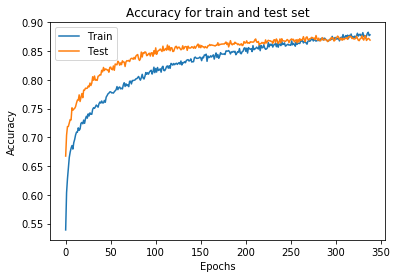

In [8]:
history = pd.read_csv(history_name)

fig, ax = plt.subplots(1,1)
ax.set_title('Accuracy for train and test set')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

x_plt = np.arange(0, len(history))
l1 = ax.plot(x_plt, history['acc'], label='Train')
l2 = ax.plot(x_plt, history['val_acc'], label='Test')

ax.legend()

plt.show()

In [9]:
X_test = np.array(df_test.drop(['Id'], axis=1))
X_test_scaled = scaler.transform(X_test)

model.load_weights(checkpoint_name)
pred = model.predict(X_test_scaled)
# convert from range 0..6 back to 1..7
y_pred = np.argmax(pred, axis=1) + 1

df_test = df_test.iloc[:, df_test.columns == 'Id']
df_test['Cover_Type'] = y_pred

df_test.to_csv('result_nn_1.csv', index=False)

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Model using the extra soil features

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

name = 'mlp_02'

df_train, df_test = get_train_test_data(add_soil_features=True)
model2, X_scaled, one_hot_labels, scaler = prepare_data_model(df_train, df_test)

# log history
history_name = 'history/' + name + '.csv'
historyLogger = CSVLogger(history_name, append=False)

# safe model checkpoints
checkpoint_name = 'checkpoints/' + name + '.hdf5'
modelCheckPoint = ModelCheckpoint(checkpoint_name, monitor='val_acc', verbose=0, save_best_only=True)

# stop training when validation loss is not decreasing
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=60)

# list with callbacks for fit_generator
callbacks = [historyLogger, modelCheckPoint, earlyStopping]

model2.fit(X_scaled, one_hot_labels, epochs=MAX_EPOCHS, batch_size=64, validation_split=0.2, callbacks=callbacks)

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Train on 12096 samples, validate on 3024 samples
Epoch 1/500
12096/12096 [==============================] - 3s 249us/step - loss: 1.2088 - acc: 0.5491 - val_loss: 0.8590 - val_acc: 0.6491
Epoch 2/500
12096/12096 [==============================] - 2s 133us/step - loss: 0.9666 - acc: 0.6059 - val_loss: 0.7658 - val_acc: 0.6786
Epoch 3/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.8958 - acc: 0.6330 - val_loss: 0.7335 - val_acc: 0.6968
Epoch 4/500
12096/12096 [==============================] - 1s 122us/step - loss: 0.8607 - acc: 0.6521 - val_loss: 0.7041 - val_acc: 0.7027
Epoch 5/500
12096/12096 [==============================] - 1s 124us/step - loss: 0.8304 - acc: 0.6639 - val_loss: 0.6878 - val_acc: 0.7080
Epoch 6/500
12096/12096 [==============================] - 2s 127us/step - loss: 0.8077 - acc: 0.6667 - val_loss: 0.7037 - val_acc: 0.7077
Epoch 7/500
12096/12096 [==============================] - 2s 130us/step - loss: 0.8023 - acc: 0.6734 - val_loss: 0.6

12096/12096 [==============================] - 2s 127us/step - loss: 0.5533 - acc: 0.7821 - val_loss: 0.4608 - val_acc: 0.8148
Epoch 60/500
12096/12096 [==============================] - 2s 126us/step - loss: 0.5409 - acc: 0.7869 - val_loss: 0.4665 - val_acc: 0.8185
Epoch 61/500
12096/12096 [==============================] - 1s 121us/step - loss: 0.5459 - acc: 0.7859 - val_loss: 0.4740 - val_acc: 0.8029
Epoch 62/500
12096/12096 [==============================] - 1s 121us/step - loss: 0.5377 - acc: 0.7882 - val_loss: 0.4670 - val_acc: 0.8085
Epoch 63/500
12096/12096 [==============================] - 1s 122us/step - loss: 0.5384 - acc: 0.7896 - val_loss: 0.4637 - val_acc: 0.8142
Epoch 64/500
12096/12096 [==============================] - 1s 122us/step - loss: 0.5346 - acc: 0.7909 - val_loss: 0.4630 - val_acc: 0.8171
Epoch 65/500
12096/12096 [==============================] - 1s 121us/step - loss: 0.5431 - acc: 0.7865 - val_loss: 0.4651 - val_acc: 0.8175
Epoch 66/500
12096/12096 [=======

12096/12096 [==============================] - 1s 123us/step - loss: 0.4586 - acc: 0.8217 - val_loss: 0.4082 - val_acc: 0.8413
Epoch 118/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.4676 - acc: 0.8189 - val_loss: 0.4177 - val_acc: 0.8406
Epoch 119/500
12096/12096 [==============================] - 1s 122us/step - loss: 0.4436 - acc: 0.8309 - val_loss: 0.4141 - val_acc: 0.8396
Epoch 120/500
12096/12096 [==============================] - 1s 120us/step - loss: 0.4453 - acc: 0.8274 - val_loss: 0.4181 - val_acc: 0.8446
Epoch 121/500
12096/12096 [==============================] - 2s 127us/step - loss: 0.4474 - acc: 0.8293 - val_loss: 0.4039 - val_acc: 0.8489
Epoch 122/500
12096/12096 [==============================] - 2s 125us/step - loss: 0.4525 - acc: 0.8251 - val_loss: 0.4066 - val_acc: 0.8492
Epoch 123/500
12096/12096 [==============================] - 1s 122us/step - loss: 0.4487 - acc: 0.8275 - val_loss: 0.4135 - val_acc: 0.8462
Epoch 124/500
12096/12096 [

12096/12096 [==============================] - 1s 122us/step - loss: 0.3993 - acc: 0.8444 - val_loss: 0.3997 - val_acc: 0.8562
Epoch 176/500
12096/12096 [==============================] - 1s 122us/step - loss: 0.3985 - acc: 0.8475 - val_loss: 0.3920 - val_acc: 0.8525
Epoch 177/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.4064 - acc: 0.8452 - val_loss: 0.3924 - val_acc: 0.8505
Epoch 178/500
12096/12096 [==============================] - 1s 121us/step - loss: 0.3992 - acc: 0.8494 - val_loss: 0.3911 - val_acc: 0.8548
Epoch 179/500
12096/12096 [==============================] - 1s 122us/step - loss: 0.3957 - acc: 0.8485 - val_loss: 0.3964 - val_acc: 0.8595
Epoch 180/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.3944 - acc: 0.8523 - val_loss: 0.3916 - val_acc: 0.8598
Epoch 181/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.3979 - acc: 0.8500 - val_loss: 0.3971 - val_acc: 0.8552
Epoch 182/500
12096/12096 [

12096/12096 [==============================] - 1s 123us/step - loss: 0.3598 - acc: 0.8642 - val_loss: 0.3785 - val_acc: 0.8621
Epoch 234/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.3703 - acc: 0.8617 - val_loss: 0.3852 - val_acc: 0.8631
Epoch 235/500
12096/12096 [==============================] - 2s 125us/step - loss: 0.3592 - acc: 0.8651 - val_loss: 0.3837 - val_acc: 0.8641
Epoch 236/500
12096/12096 [==============================] - 1s 122us/step - loss: 0.3679 - acc: 0.8570 - val_loss: 0.3853 - val_acc: 0.8621
Epoch 237/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.3649 - acc: 0.8600 - val_loss: 0.3852 - val_acc: 0.8611
Epoch 238/500
12096/12096 [==============================] - 1s 122us/step - loss: 0.3666 - acc: 0.8631 - val_loss: 0.3849 - val_acc: 0.8601
Epoch 239/500
12096/12096 [==============================] - 2s 125us/step - loss: 0.3601 - acc: 0.8637 - val_loss: 0.3791 - val_acc: 0.8631
Epoch 240/500
12096/12096 [

12096/12096 [==============================] - 1s 120us/step - loss: 0.3415 - acc: 0.8750 - val_loss: 0.3798 - val_acc: 0.8700
Epoch 292/500
12096/12096 [==============================] - 1s 124us/step - loss: 0.3386 - acc: 0.8735 - val_loss: 0.3720 - val_acc: 0.8671
Epoch 293/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.3445 - acc: 0.8678 - val_loss: 0.3846 - val_acc: 0.8647
Epoch 294/500
12096/12096 [==============================] - 1s 122us/step - loss: 0.3401 - acc: 0.8772 - val_loss: 0.3795 - val_acc: 0.8697
Epoch 295/500
12096/12096 [==============================] - 1s 123us/step - loss: 0.3333 - acc: 0.8724 - val_loss: 0.3855 - val_acc: 0.8624
Epoch 296/500
12096/12096 [==============================] - 1s 120us/step - loss: 0.3350 - acc: 0.8764 - val_loss: 0.3826 - val_acc: 0.8651
Epoch 297/500
12096/12096 [==============================] - 1s 124us/step - loss: 0.3338 - acc: 0.8761 - val_loss: 0.3796 - val_acc: 0.8664
Epoch 298/500
12096/12096 [

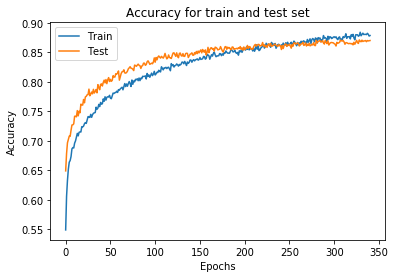

In [11]:
history = pd.read_csv(history_name)

fig, ax = plt.subplots(1,1)
ax.set_title('Accuracy for train and test set')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

x_plt = np.arange(0, len(history))
l1 = ax.plot(x_plt, history['acc'], label='Train')
l2 = ax.plot(x_plt, history['val_acc'], label='Test')

ax.legend()

plt.show()

In [12]:
X_test = np.array(df_test.drop(['Id'], axis=1))
X_test_scaled = scaler.transform(X_test)

model2.load_weights(checkpoint_name)
pred = model2.predict(X_test_scaled)
# convert from range 0..6 back to 1..7
y_pred = np.argmax(pred, axis=1) + 1

df_test = df_test.iloc[:, df_test.columns == 'Id']
df_test['Cover_Type'] = y_pred

df_test.to_csv('result_nn.csv', index=False)

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
